# Spotify Recommendation System

- It's an Item-based Collaborative filtered recommendation system.

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import spotipy
import json 
import re
import spotipy.util as util
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#loading files from local
data1= json.load(open('mpd.slice.0-999.json'))
data2= json.load(open('mpd.slice.1000-1999.json'))
data3= json.load(open('mpd.slice.2000-2999.json'))
data4= json.load(open('mpd.slice.3000-3999.json'))
df1= pd.DataFrame(data1['playlists'])
df2= pd.DataFrame(data2['playlists'])
df3= pd.DataFrame(data3['playlists'])
df4= pd.DataFrame(data4['playlists'])
df= pd.concat([df1, df2, df3, df4])

#Making a single dataset by merging all in one
df= df.explode('tracks')
df= pd.concat([df.drop(['tracks'], axis=1), df['tracks'].apply(pd.Series)],axis=1) 

# renaming the columns with the same name
df.columns=['name', 'collaborative', 'pid', 'modified_at', 'num_tracks',
       'num_albums', 'num_followers', 'num_edits', 'playlist_duration_ms',
       'num_artists', 'description', 'pos', 'artist_name', 'track_uri',
       'artist_uri', 'track_name', 'album_uri', 'track_duration_ms',
       'album_name']

In [3]:
#checking the shape of the dataset
df.shape

(266386, 19)

In [4]:
#using just uri of tracks and artists
df['track_uri']= df["track_uri"].apply(lambda x: re.findall(r'\w+$', str(x))[0])
df['artist_uri']= df["artist_uri"].apply(lambda x: re.findall(r'\w+$', str(x))[0])

In [5]:
#checking the dataset
df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_ms,album_name
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,4,Shaggy,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


In [6]:
#checking the number of unique tracks and artists
print(df.track_uri.nunique())
print(df.artist_name.nunique())

93139
22051


## Feature Extraction using Spotify API

In [7]:
#importing necessary libraries for authenication
import spotipy
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials

In [8]:
key = 'b6c69f9f6e414ce5b43cb6caa6a257bb'
secret = '319e1dba434c4601ba9daf986adfc260'

In [9]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=key, client_secret=secret)
api = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [10]:
#checking the track info feature
api.track('0WqIKmW4BTrj3eJFmnCKMv')

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6vWDO969PvNqNYHIOW5v0m'},
    'href': 'https://api.spotify.com/v1/artists/6vWDO969PvNqNYHIOW5v0m',
    'id': '6vWDO969PvNqNYHIOW5v0m',
    'name': 'Beyoncé',
    'type': 'artist',
    'uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m'}],
  'available_markets': ['CH', 'LI'],
  'external_urls': {'spotify': 'https://open.spotify.com/album/25hVFAxTlDvXbx2X2QkUkE'},
  'href': 'https://api.spotify.com/v1/albums/25hVFAxTlDvXbx2X2QkUkE',
  'id': '25hVFAxTlDvXbx2X2QkUkE',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/ab67616d0000b27390592f54226a3eb8a99feea6',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/ab67616d00001e0290592f54226a3eb8a99feea6',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/ab67616d0000485190592f54226a3eb8a99feea6',
    'width': 64}],
  'name': 'Dangerously In Love (Alben für die Ewigkeit)',
  'rele

In [11]:
#checking the popularity of a random track
track_feature_info= api.track('0WqIKmW4BTrj3eJFmnCKMv')
popularity = track_feature_info['popularity']
popularity

21

In [12]:
#checking the audio features of a random track
api.audio_features('0XUfyU2QviPAs6bxSpXYG4')

[{'danceability': 0.881,
  'energy': 0.788,
  'key': 2,
  'loudness': -4.669,
  'mode': 1,
  'speechiness': 0.168,
  'acousticness': 0.0212,
  'instrumentalness': 0,
  'liveness': 0.0377,
  'valence': 0.592,
  'tempo': 104.997,
  'type': 'audio_features',
  'id': '0XUfyU2QviPAs6bxSpXYG4',
  'uri': 'spotify:track:0XUfyU2QviPAs6bxSpXYG4',
  'track_href': 'https://api.spotify.com/v1/tracks/0XUfyU2QviPAs6bxSpXYG4',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0XUfyU2QviPAs6bxSpXYG4',
  'duration_ms': 250373,
  'time_signature': 4}]

In [13]:
#function to extract track features

def getTrackFeatures(id):
    features_info= api.audio_features(id)
    track_feature_info= api.track(id)
    track_popularity = track_feature_info['popularity']
    key = features_info[0]['key']
    acousticness = features_info[0]['acousticness']
    danceability =features_info[0]['danceability']
    energy = features_info[0]['energy']
    instrumentalness = features_info[0]['instrumentalness']
    liveness =features_info[0]['liveness']
    loudness = features_info[0]['loudness']
    speechiness = features_info[0]['speechiness']
    tempo =features_info[0]['tempo']
    time_signature = features_info[0]['time_signature']
    track_data = [key,acousticness, danceability, energy, instrumentalness, liveness, 
                  loudness, speechiness, tempo, time_signature,track_popularity]
    return track_data

In [14]:
#function to extract artist features

def artistInfo(ID):
    artist_info = api.artist(ID)
    artist_name = artist_info['name']
    artist_popularity = artist_info['popularity']
    
    artist_data = [artist_name, artist_popularity]
    return artist_data

In [17]:
track_list =[]
artist_list = []

In [18]:
#extracting the features and appending them into a list
i = 0
while i < 200:
    track_data = getTrackFeatures(df['track_uri'].iloc[i]) 
    artist_data = artistInfo(df['artist_uri'].iloc[i])
    artist_list.append(artist_data)
    track_list.append(track_data)
    i+=1

- Using only 20 features to do basic analysis

In [19]:
#converting lists into dataframe
df_track = pd.DataFrame(track_list, columns = ['Acousticness', 'Danceability','key','Energy','Instrumentalness', 
                                               'Liveness', 'Loudness', 'Speechiness', 
                                                  'Tempo', 'Time Signature','Track_popularity'])
df_artist = pd.DataFrame(artist_list, columns = ['Artist','Artist_popularity'])

In [20]:
#concating the dataframe into one
data = pd.concat([df_artist,df_track], axis=1)
data.head()

,Artist,Artist_popularity,Acousticness,Danceability,key,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time Signature,Track_popularity
0,Missy Elliott,70,4,0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,4,67
1,Britney Spears,81,5,0.02490,0.774,0.838,0.025000,0.2420,-3.914,0.1140,143.040,4,81
2,Beyoncé,88,2,0.00238,0.664,0.758,0.000000,0.0598,-6.583,0.2100,99.259,4,21
3,Justin Timberlake,80,4,0.20100,0.892,0.714,0.000234,0.0521,-6.055,0.1410,100.972,4,76
4,Shaggy,72,0,0.05610,0.853,0.606,0.000000,0.3130,-4.596,0.0713,94.759,4,0


#### Ad hoc analysis

## Descriptive and Statistical Analysis

In [21]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Artist_popularity,200.0,61.090000,17.585453,0.00000,53.000000,63.000000,72.000000,91.000
Acousticness,200.0,4.950000,3.468089,0.00000,2.000000,4.500000,8.000000,11.000
Danceability,200.0,0.204371,0.254285,0.00001,0.007808,0.087550,0.310500,0.988
key,200.0,0.607020,0.157184,0.08490,0.502500,0.626500,0.725250,0.938
Energy,200.0,0.700491,0.200671,0.06820,0.600750,0.731000,0.853250,0.976
Instrumentalness,200.0,0.082693,0.239407,0.00000,0.000000,0.000002,0.001723,0.991
Liveness,200.0,0.182724,0.136007,0.02680,0.089250,0.132500,0.247500,0.869
Loudness,200.0,-6.469830,3.586225,-29.91700,-8.061250,-5.620000,-4.285250,-1.029
Speechiness,200.0,0.094814,0.094672,0.02550,0.038875,0.055750,0.108000,0.505
Tempo,200.0,121.409895,29.049327,48.97300,99.195500,120.204500,141.291750,210.857


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266386 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   name                  266386 non-null  object
 1   collaborative         266386 non-null  object
 2   pid                   266386 non-null  int64 
 3   modified_at           266386 non-null  int64 
 4   num_tracks            266386 non-null  int64 
 5   num_albums            266386 non-null  int64 
 6   num_followers         266386 non-null  int64 
 7   num_edits             266386 non-null  int64 
 8   playlist_duration_ms  266386 non-null  int64 
 9   num_artists           266386 non-null  int64 
 10  description           5333 non-null    object
 11  pos                   266386 non-null  int64 
 12  artist_name           266386 non-null  object
 13  track_uri             266386 non-null  object
 14  artist_uri            266386 non-null  object
 15  track_name          

In [23]:
df['num_tracks'].nunique()

241

In [24]:
def detailed_analysis(data, pred=None):
    obs = data.shape[0]
    types = data.dtypes
    counts = data.apply(lambda x:x.count())
    uniques = data.apply(lambda x: x.unique())
    nulls = data.apply(lambda x:x.isnull().sum())
    distincts = data.apply(lambda x:x.nunique())
    missing_ratio = (data.isnull().sum()/obs)*100
    skewness = data.skew()
    kurtosis = data.kurt()
    print('Data shape:', data.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'nulls', 'distincts', 
                'missing ratio', 'uniques', 'skewness', 'kurtosis']
        details = pd.concat([types, counts, nulls, distincts, missing_ratio, uniques, skewness, kurtosis], axis=1)
    else:
        corr = data.corr()[pred]
        details = pd.concat([types, counts, nulls, distincts, missing_ratio, uniques, skewness, kurtosis, corr], axis=1, sort=False)
        corr_col = 'corr ' + pred
        cols = ['types', 'counts', 'nulls', 'distincts', 'missing ratio', 'uniques', 'skewness', 'kurtosis', corr_col]

    details.columns = cols
    dtypes = details.types.value_counts()
    print('____________________________\nData types:\n', dtypes)
    print('____________________________')
    return details

In [25]:
details = detailed_analysis(data, 'Energy')
display(details.sort_values(by='corr Energy', ascending=False))

Data shape: (200, 13)
____________________________
Data types:
 float64    8
int64      4
object     1
Name: types, dtype: int64
____________________________


,types,counts,nulls,distincts,missing ratio,uniques,skewness,kurtosis,corr Energy
Energy,float64,200,0,177,0.0,"[0.813, 0.838, 0.758, 0.714, 0.606, 0.788, 0.5...",-0.902537,0.330798,1.000000
Loudness,float64,200,0,198,0.0,"[-7.105, -3.914, -6.583, -6.055, -4.596, -4.66...",-2.391956,10.151715,0.706399
Tempo,float64,200,0,197,0.0,"[125.461, 143.04, 99.259, 100.972, 94.759, 104...",0.312942,-0.260141,0.197291
Time Signature,int64,200,0,3,0.0,"[4, 3, 1]",-7.074398,55.273811,0.163993
Track_popularity,int64,200,0,64,0.0,"[67, 81, 21, 76, 0, 77, 65, 82, 72, 63, 74, 41...",0.222078,-1.568629,0.062528
Liveness,float64,200,0,168,0.0,"[0.0471, 0.242, 0.0598, 0.0521, 0.313, 0.0377,...",1.863959,4.674321,0.054419
Artist_popularity,int64,200,0,57,0.0,"[70, 81, 88, 80, 72, 78, 68, 74, 60, 62, 76, 8...",-0.725007,0.994869,0.021382
Instrumentalness,float64,200,0,103,0.0,"[0.00697, 0.025, 0.0, 0.000234, 0.000532, 6.13...",2.927499,7.086712,-0.000274
Speechiness,float64,200,0,178,0.0,"[0.121, 0.114, 0.21, 0.141, 0.0713, 0.168, 0.1...",2.401917,5.963760,-0.024668
Acousticness,int64,200,0,12,0.0,"[4, 5, 2, 0, 10, 9, 8, 1, 7, 11, 3, 6]",0.208211,-1.258624,-0.065545


In [26]:
data.Artist.value_counts()

BTS                8
Rush               7
Daniel Tidwell     6
Jay Park           6
Jesse McCartney    4
                  ..
Iyaz               1
Kesha              1
Lovelyz            1
M.I.A.             1
Missy Elliott      1
Name: Artist, Length: 120, dtype: int64

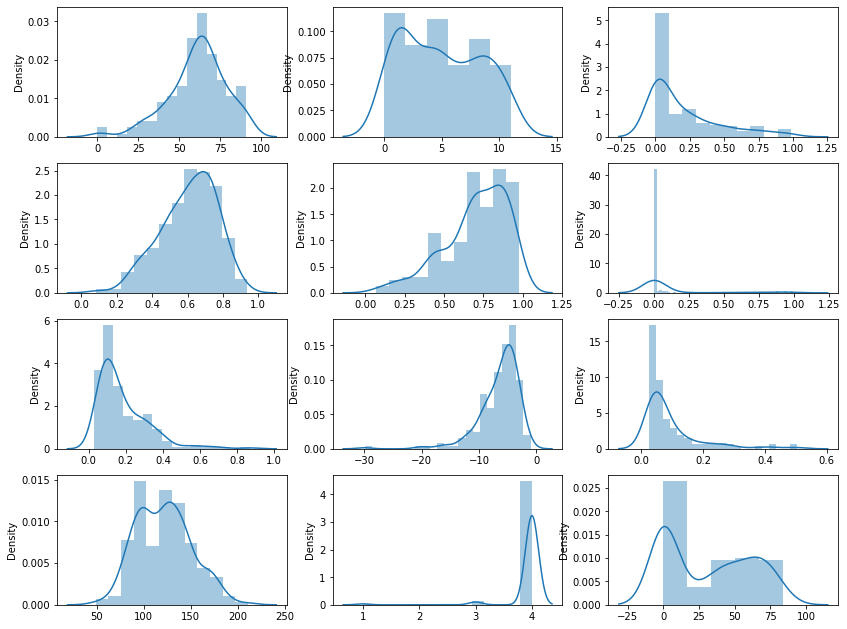

In [27]:
f = plt.figure(figsize=(14,11))
for i in range(1,13):
    f.add_subplot(4, 3, i)
    sns.distplot(x=data.iloc[:,i])
plt.show()

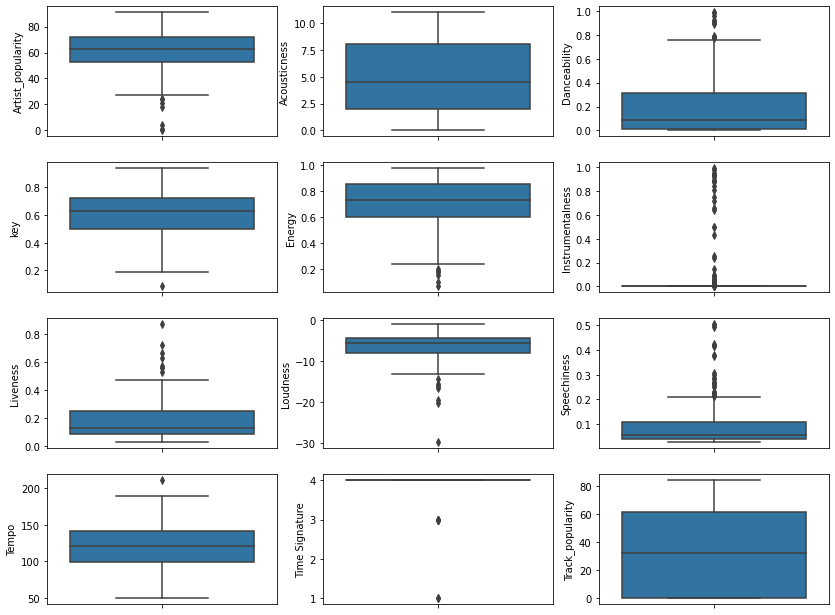

In [34]:
f = plt.figure(figsize=(14,11))
for i in range(1,13):
    f.add_subplot(4, 3, i)
    sns.boxplot(y=data.iloc[:,i])
plt.show()

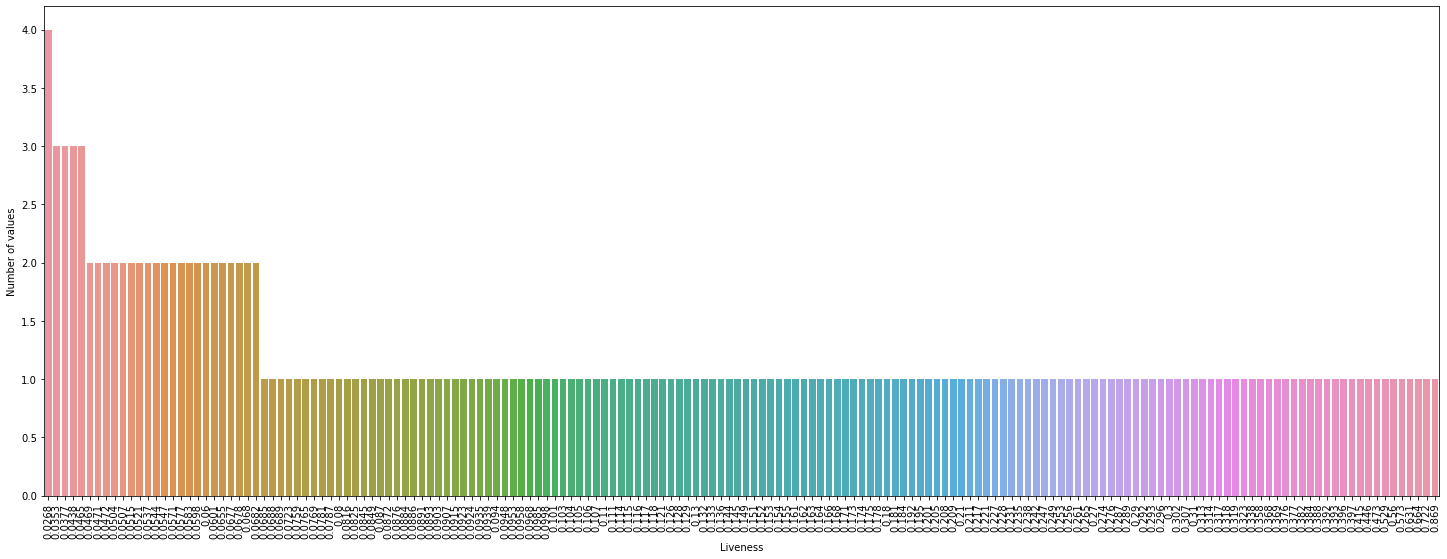

In [32]:
values = data.Liveness.value_counts()
indexes = values.index.sort_values()

fig = plt.figure(figsize=(25, 9))
sns.barplot(indexes, values)

plt.ylabel('Number of values')
plt.xlabel('Liveness')
plt.xticks(rotation=90)
plt.show()

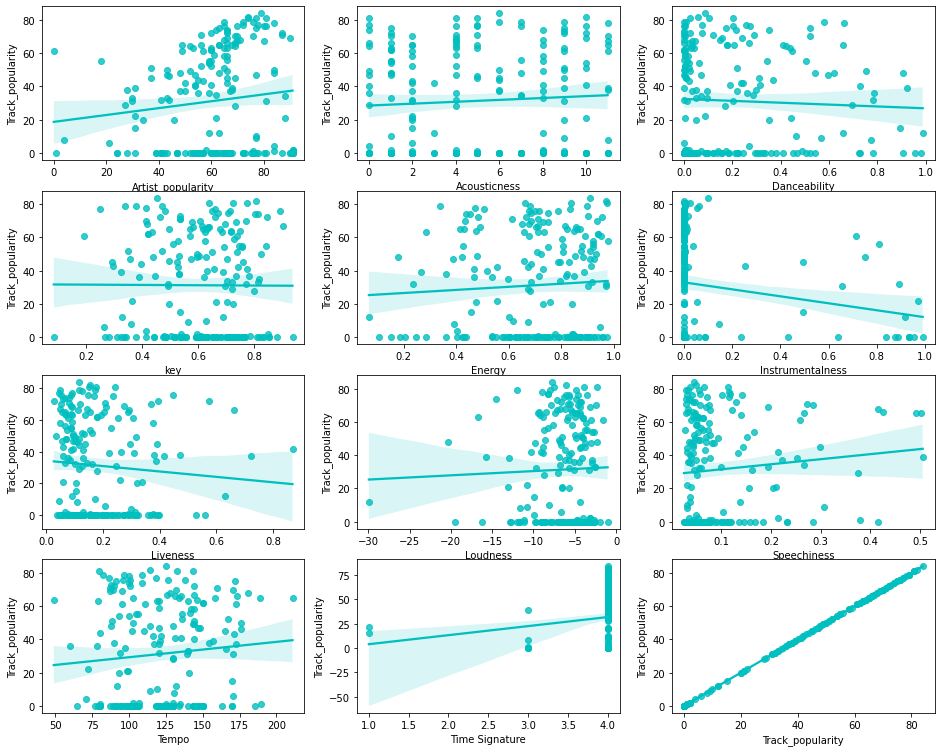

In [29]:
f = plt.figure(figsize=(16,13))
for i in range(1,13):
    f.add_subplot(4, 3, i)
    sns.regplot(x=data.iloc[:,i], y='Track_popularity',data=data, color='c')
plt.show()

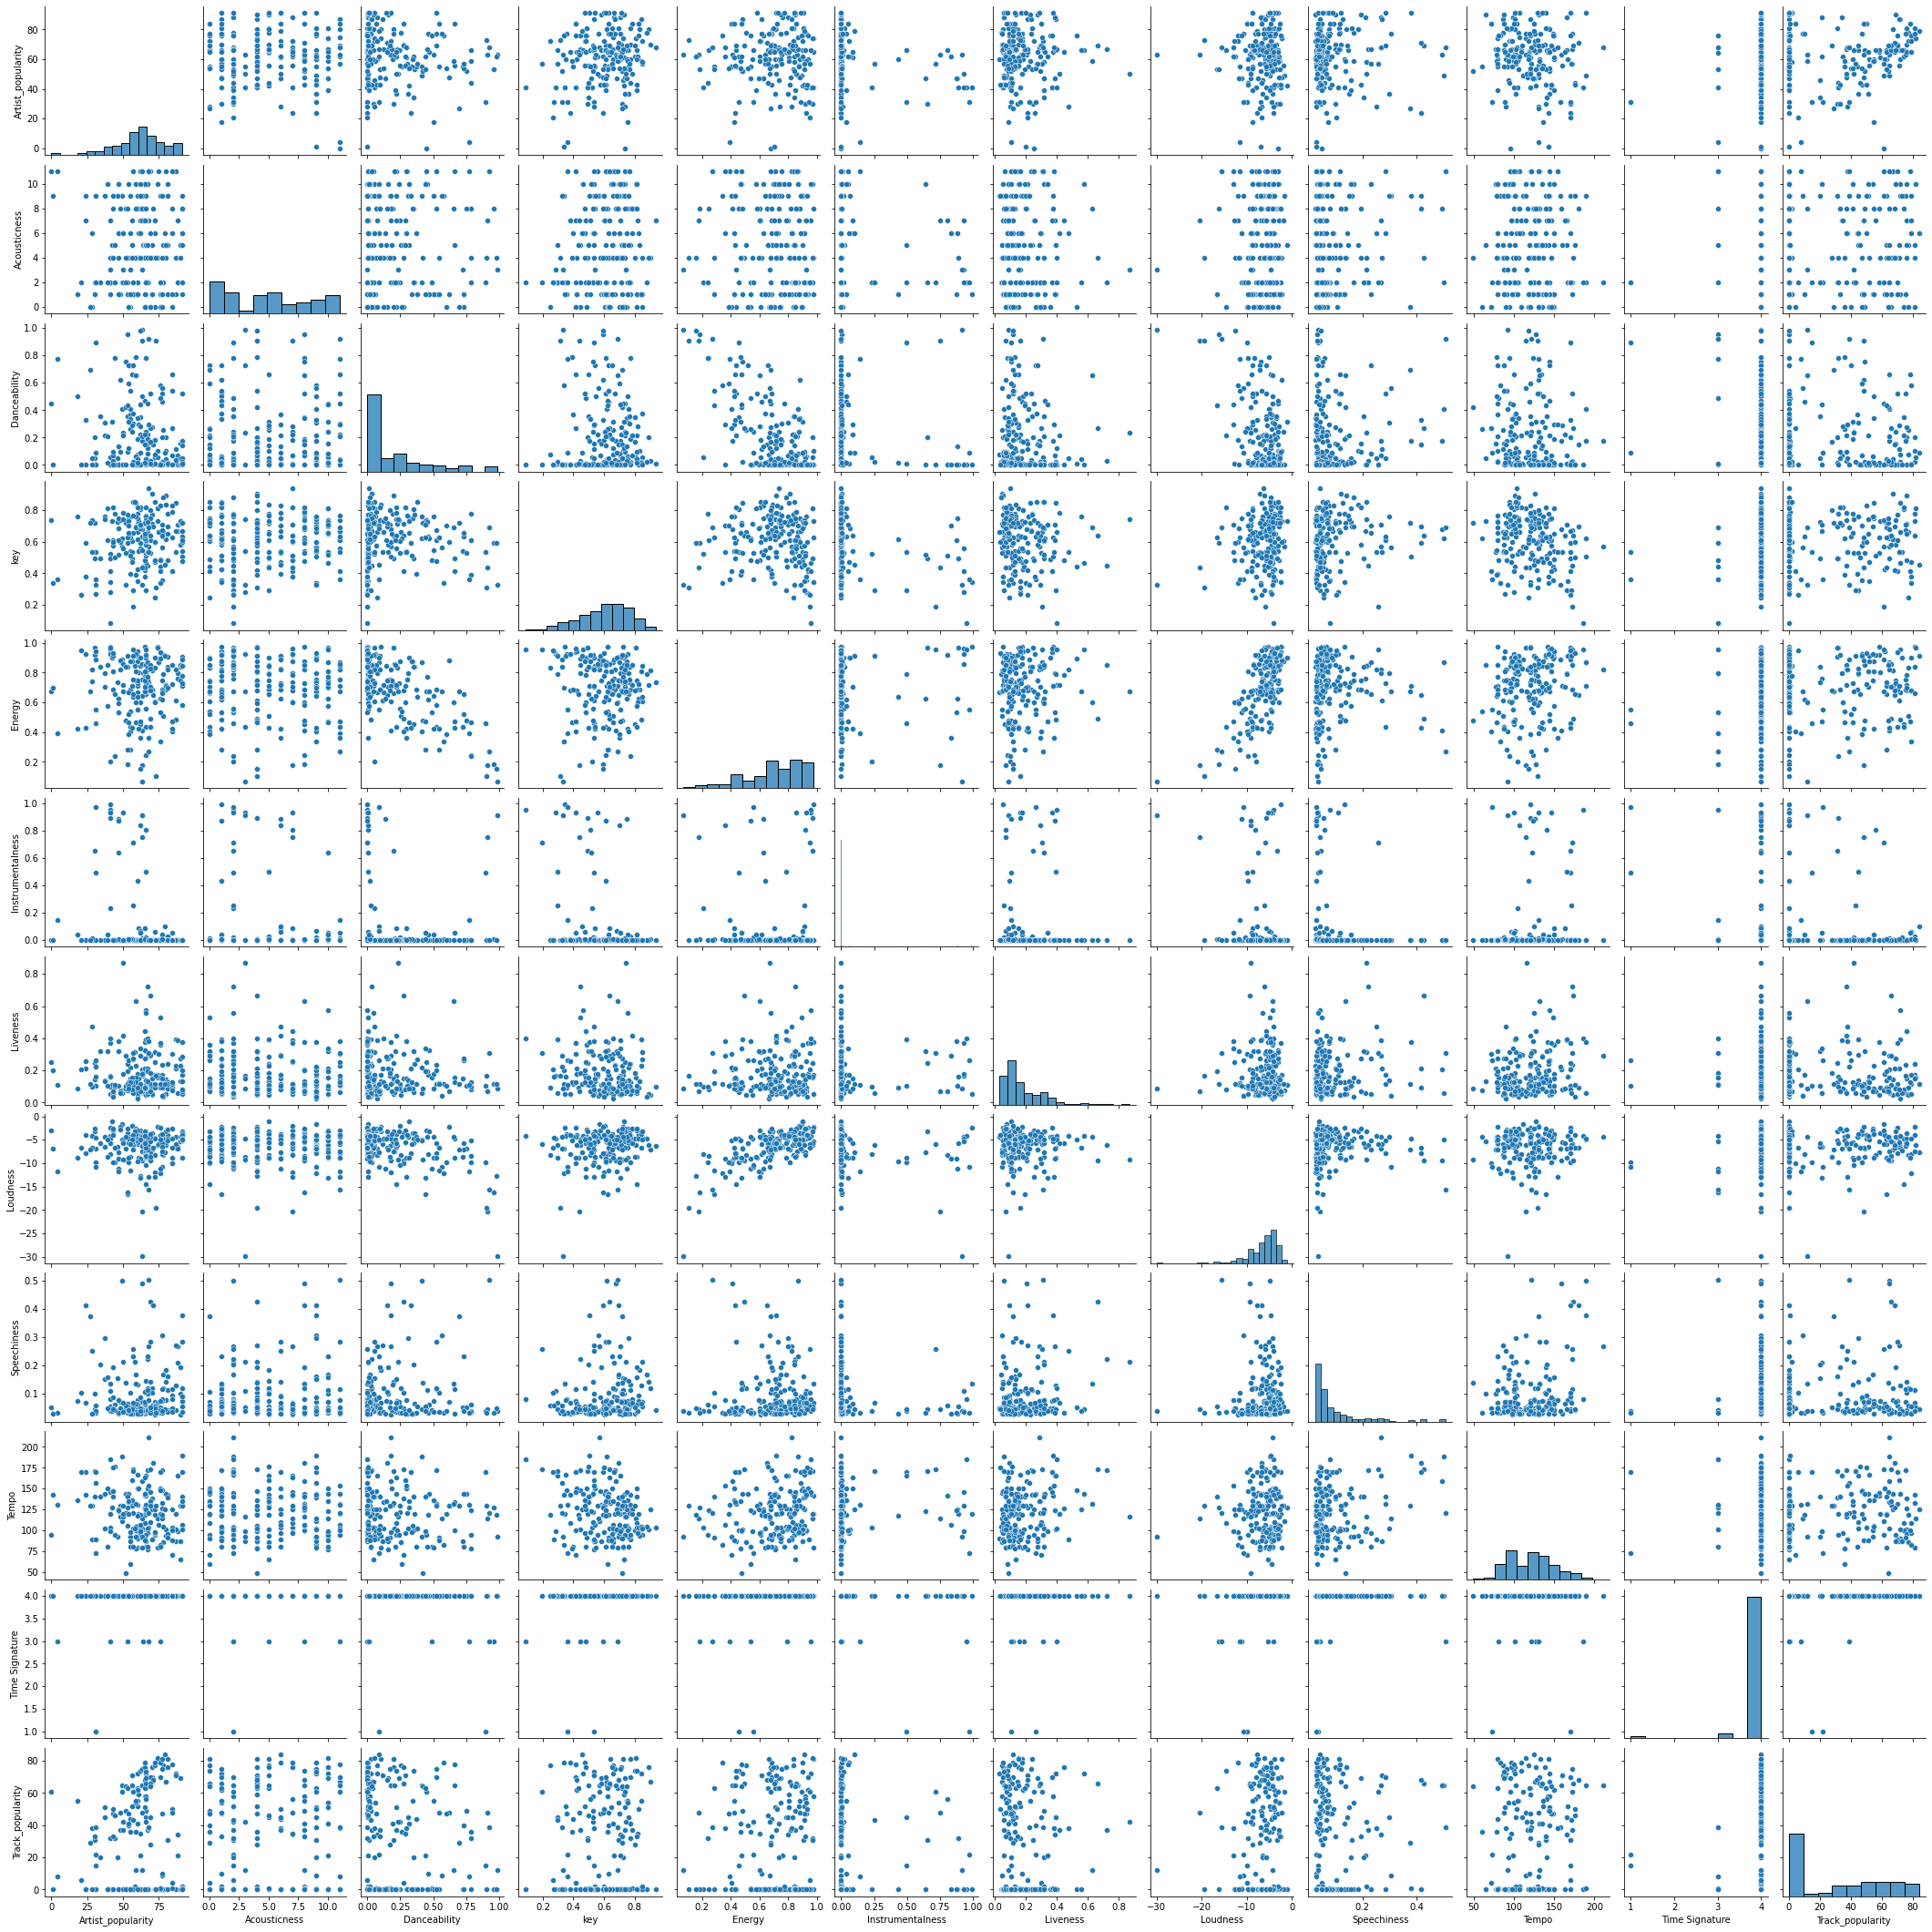

In [30]:
sns.pairplot(data)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

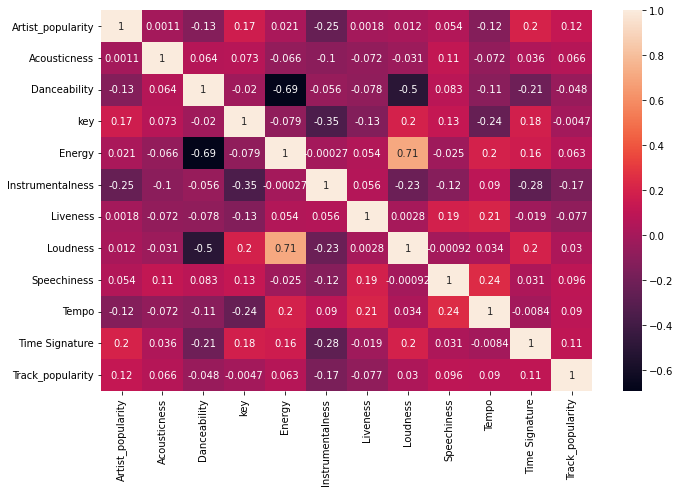

In [31]:
plt.figure(figsize=(11,7))
sns.heatmap(data.corr(), annot=True)
plt.show